# RF Model
# Survival of Titanic Pasengers: Developing Predictive Machine Learning Models 

## Version 3: Feature Engineering V2

### Data processing

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# load data
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
test_ids = test["PassengerId"]

In [18]:
from sklearn import preprocessing

def label_encode_columns(df, columns):
    # Initialize the label encoder
    le = preprocessing.LabelEncoder()

    # Dictionary to store the mapping of original categories to their encoded values
    label_mapping = {}

    # Apply label encoding to the specified columns
    for col in columns:
        df[col] = le.fit_transform(df[col])
        
        # Store the mapping of the original categories to their encoded values
        label_mapping[col] = {class_label: index for index, class_label in enumerate(le.classes_)}

    # Display the transformation
    for col, mapping in label_mapping.items():
        print(f"'{col}' transformation:")
        for key, value in mapping.items():
            print(f"  {key} -> {value}")



In [19]:
# import strings
import re
from sklearn.ensemble import ExtraTreesRegressor

def data_process(df):
    # Calculate the mode value for 'Fare'
    fare_mode = df['Fare'].mode()[0]  # mode() returns a Series, get the first element
    # Replace NaN values in 'Fare' with the mode value
    df['Fare'].fillna(fare_mode, inplace=True)
    # Bin the fare data into ranges (e.g., 0-10, 10-20, etc.)
    # Zero fare is included in the first bin
    fare_bins = [-0.01, 25, 50, 100, 200, 300, 600]
    fare_labels = ['0-25', '25-50', '50-100', '100-200', '200-300', '300+']    
    df['FareGroup'] = pd.cut(df['Fare'], bins=fare_bins, labels=fare_labels, right=True)
    
    # Remove rows where the 'Embarked' column has missing values
    df.dropna(subset=['Embarked'], inplace=True)
    
    # Remove the 'Cabin' column from the DataFrame
    df.drop(columns=['Cabin'], inplace = True)

    # Create a new feature 'FamilySize'
    df['FamilySize'] = df["SibSp"] + df["Parch"]
    # Define the bins and labels
    bins = [-0.01, 3, 5, 11]  # Adjust the ranges as necessary
    labels = ['small', 'medium', 'large']   
    # Categorize FamilySize
    df['FamilySize'] = pd.cut(df['FamilySize'], bins=bins, labels=labels, right=False)

    # Define the regex pattern to match titles
    title_pattern = r'\b(Mrs|Mr|Master|Miss|Major|Rev|Dr|Ms|Mlle|Col|Capt|Mme|Countess|Don|Jonkheer|Dona)\b'   
    # Extract titles using the regex pattern
    df['Title'] = df['Name'].apply(lambda x: re.search(title_pattern, x).group(0) if re.search(title_pattern, x) else np.nan)    
    # Replace titles with Mr, Mrs, Miss, Master categories
    def replace_titles(title, sex):
        if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
            return 'Mr'
        elif title in ['Countess', 'Mme', 'Dona']:
            return 'Mrs'
        elif title in ['Mlle', 'Ms']:
            return 'Miss'
        elif title == 'Dr':
            return 'Mr' if sex == 'Male' else 'Mrs'
        else:
            return title
    # Apply the replacement function
    df['Title'] = df.apply(lambda x: replace_titles(x['Title'], x['Sex']), axis=1)
    
    classers = ["Sex", "Embarked", "FamilySize", "SibSp", "Title", "Parch", "Pclass", "FareGroup"]
    label_encode_columns(df, classers)
    age_et = ExtraTreesRegressor(n_estimators=200)    
    X_train = df.loc[df['Age'].notnull(),classers]
    Y_train = df.loc[df['Age'].notnull(),['Age']]
    X_test = df.loc[df['Age'].isnull(),classers]    
    age_et.fit(X_train,np.ravel(Y_train))
    age_predictions = age_et.predict(X_test)    
    df.loc[df['Age'].isnull(),['Age']] = age_predictions
    
    # Calculate the mode value for 'Age'
    # age_mode = df['Age'].mode()[0]  # mode() returns a Series, get the first element
    # # Replace NaN values in 'Age' with the mode value
    # df['Age'].fillna(age_mode, inplace=True)
    # Bin the age data into ranges (e.g., 0-10, 10-20, etc.)
    age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    age_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
    df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)

    child_age = 12
    def get_life_phase(passenger):
        age, sex = passenger
        if (age < child_age):
            return 'child'
        elif (sex == 0):
            return 'female_adult'
        else:
            return 'male_adult'
    df['LifePhase'] = df[['Age', 'Sex']].apply(lambda row: get_life_phase(row),axis=1)

    # Drop unwanted columns if they exist
    columns_to_drop = ["PassengerId", "Name", "SibSp", "Parch", "Ticket", "Age", "Fare"]
    existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]    
    if existing_columns_to_drop:
        df.drop(columns=existing_columns_to_drop, inplace=True)
        
data_process(train)
data_process(test)

'Sex' transformation:
  female -> 0
  male -> 1
'Embarked' transformation:
  C -> 0
  Q -> 1
  S -> 2
'FamilySize' transformation:
  large -> 0
  medium -> 1
  small -> 2
'SibSp' transformation:
  0 -> 0
  1 -> 1
  2 -> 2
  3 -> 3
  4 -> 4
  5 -> 5
  8 -> 6
'Title' transformation:
  Master -> 0
  Miss -> 1
  Mr -> 2
  Mrs -> 3
'Parch' transformation:
  0 -> 0
  1 -> 1
  2 -> 2
  3 -> 3
  4 -> 4
  5 -> 5
  6 -> 6
'Pclass' transformation:
  1 -> 0
  2 -> 1
  3 -> 2
'FareGroup' transformation:
  0-25 -> 0
  100-200 -> 1
  200-300 -> 2
  25-50 -> 3
  300+ -> 4
  50-100 -> 5
'Sex' transformation:
  female -> 0
  male -> 1
'Embarked' transformation:
  C -> 0
  Q -> 1
  S -> 2
'FamilySize' transformation:
  large -> 0
  medium -> 1
  small -> 2
'SibSp' transformation:
  0 -> 0
  1 -> 1
  2 -> 2
  3 -> 3
  4 -> 4
  5 -> 5
  8 -> 6
'Title' transformation:
  Master -> 0
  Miss -> 1
  Mr -> 2
  Mrs -> 3
'Parch' transformation:
  0 -> 0
  1 -> 1
  2 -> 2
  3 -> 3
  4 -> 4
  5 -> 5
  6 -> 6
  9 -> 

In [20]:
cols = ["AgeGroup", "LifePhase"]
label_encode_columns(train, cols)
label_encode_columns(test, cols)

'AgeGroup' transformation:
  0-10 -> 0
  10-20 -> 1
  20-30 -> 2
  30-40 -> 3
  40-50 -> 4
  50-60 -> 5
  60-70 -> 6
  70-80 -> 7
'LifePhase' transformation:
  child -> 0
  female_adult -> 1
  male_adult -> 2
'AgeGroup' transformation:
  0-10 -> 0
  10-20 -> 1
  20-30 -> 2
  30-40 -> 3
  40-50 -> 4
  50-60 -> 5
  60-70 -> 6
  70-80 -> 7
'LifePhase' transformation:
  child -> 0
  female_adult -> 1
  male_adult -> 2


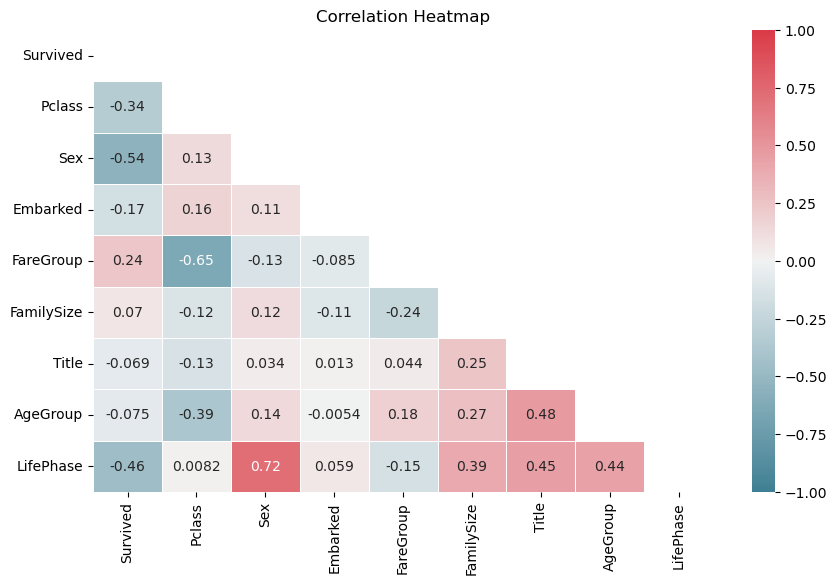

In [21]:
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(), 
            mask=np.triu(np.ones_like(train.corr(), dtype=bool)),
            annot=True, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            vmax=1,
            vmin=-1, 
            linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

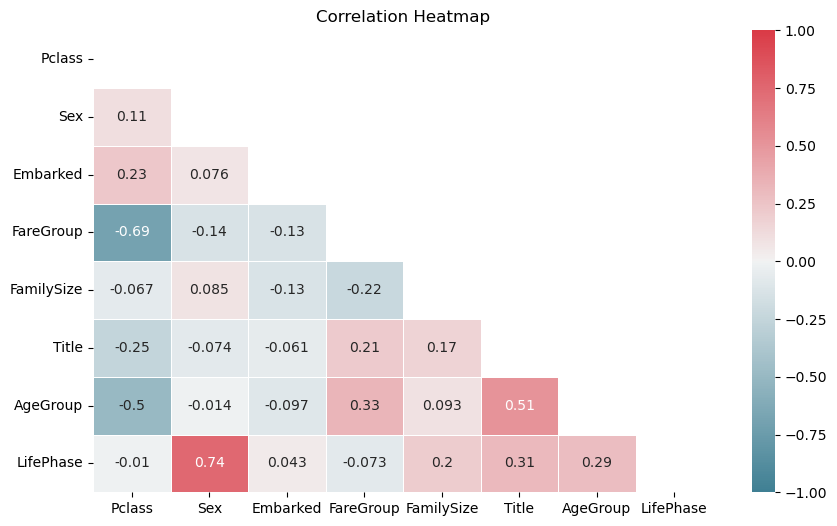

In [22]:
plt.figure(figsize=(10,6))
sns.heatmap(test.corr(), 
            mask=np.triu(np.ones_like(test.corr(), dtype=bool)),
            annot=True, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            vmax=1,
            vmin=-1, 
            linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Random Forest

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler

# Define target and features
y = train["Survived"]
X = train.drop("Survived", axis = 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [24]:
def evaluate_model_performance_RF(model, X_val, y_val, X_train):
    """
    Evaluates the performance of a trained model on a validation set.

    Parameters:
    - model: Trained model (e.g., Logistic Regression, SVC, RandomForestClassifier, XGBClassifier)
    - X_val: Validation features
    - y_val: True labels for the validation set
    - title_size: Font size for plot titles
    - label_size: Font size for axis labels
    - tick_size: Font size for tick labels
    - legend_size: Font size for legend
    - X_train: Training features
    
    Outputs:
    - Prints accuracy and classification report
    - Plots Confusion Matrix, ROC curve, Precision-Recall curve, and Feature Importance (if applicable)
    """
    title_size=18 
    label_size=16
    tick_size=16 
    legend_size=16
    annot_size=16
    
    # Predict on the validation set
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]  # Probabilities for ROC and Precision-Recall curves

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    
    # Generate classification report
    class_report = classification_report(y_val, y_pred)
    print('Classification Report:')
    print(class_report)
    
    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred)
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_val, y_prob)
    
    # Create subplots
    fig, ax = plt.subplots(2, 2, figsize=(18, 12))
    
    # Plot Confusion Matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'], 
                yticklabels=['Class 0', 'Class 1'], ax=ax[0, 0], annot_kws={"size": annot_size})
    ax[0, 0].set_xlabel('Predicted', fontsize=label_size)
    ax[0, 0].set_ylabel('Actual', fontsize=label_size)
    ax[0, 0].set_title('Confusion Matrix', fontsize=title_size)
    ax[0, 0].tick_params(axis='both', which='major', labelsize=tick_size)
    
    # Plot ROC Curve
    ax[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0, 1].set_xlim([0.0, 1.0])
    ax[0, 1].set_ylim([0.0, 1.05])
    ax[0, 1].set_xlabel('False Positive Rate', fontsize=label_size)
    ax[0, 1].set_ylabel('True Positive Rate', fontsize=label_size)
    ax[0, 1].set_title('Receiver Operating Characteristic', fontsize=title_size)
    ax[0, 1].legend(loc='lower right', fontsize=legend_size)
    ax[0, 1].tick_params(axis='both', which='major', labelsize=tick_size)
    
    # Plot Precision-Recall Curve
    ax[1, 0].plot(recall, precision, color='b')
    ax[1, 0].set_xlabel('Recall', fontsize=label_size)
    ax[1, 0].set_ylabel('Precision', fontsize=label_size)
    ax[1, 0].set_title('Precision-Recall Curve', fontsize=title_size)
    ax[1, 0].tick_params(axis='both', which='major', labelsize=tick_size)
    
    # Plot Feature Importance (for XGBoost models)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)
        features = X_val.columns
        
        ax[1, 1].barh(range(len(indices)), importances[indices], align='center')
        ax[1, 1].set_yticks(range(len(indices)))
        ax[1, 1].set_yticklabels(features[indices], fontsize=tick_size)
        ax[1, 1].set_xlabel('Importance', fontsize=label_size)
        ax[1, 1].set_title('Feature Importance', fontsize=title_size)
        ax[1, 1].tick_params(axis='both', which='major', labelsize=tick_size)
    else:
        ax[1, 1].text(0.5, 0.5, 'No Feature Importance Plot', horizontalalignment='center', verticalalignment='center', fontsize=label_size, color='gray')
        ax[1, 1].set_title('Placeholder', fontsize=title_size)
    
    # Adjust layout for previous plots (if any)
    plt.tight_layout()
    plt.show()
    
    # Identify all features from the training data
    features_of_interest = X_train.columns.tolist()
    
    # Define number of columns and calculate the number of rows needed
    num_cols = 3
    num_rows = (len(features_of_interest) + num_cols - 1) // num_cols  # Round up the number of rows
    
    # Generate partial dependence plots
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 4 * num_rows))
    
    # Flatten ax if it's a multi-dimensional array, otherwise keep it as a list
    ax = ax.flatten()
    
    display = PartialDependenceDisplay.from_estimator(model, X_train, features_of_interest, ax=ax[:len(features_of_interest)], grid_resolution=50)
    
    # Add x-axis labels manually
    for i, feature_name in enumerate(features_of_interest):
        ax[i].set_xlabel(feature_name)
        ax[i].set_ylabel('Partial Dependence')
    
    # Remove any empty subplots if the number of features is not a multiple of num_cols
    for j in range(len(features_of_interest), len(ax)):
        fig.delaxes(ax[j])
    
    # Display the plot
    plt.tight_layout()
    plt.show()



Accuracy: 0.8315
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.87       109
           1       0.87      0.67      0.75        69

    accuracy                           0.83       178
   macro avg       0.84      0.80      0.81       178
weighted avg       0.84      0.83      0.83       178



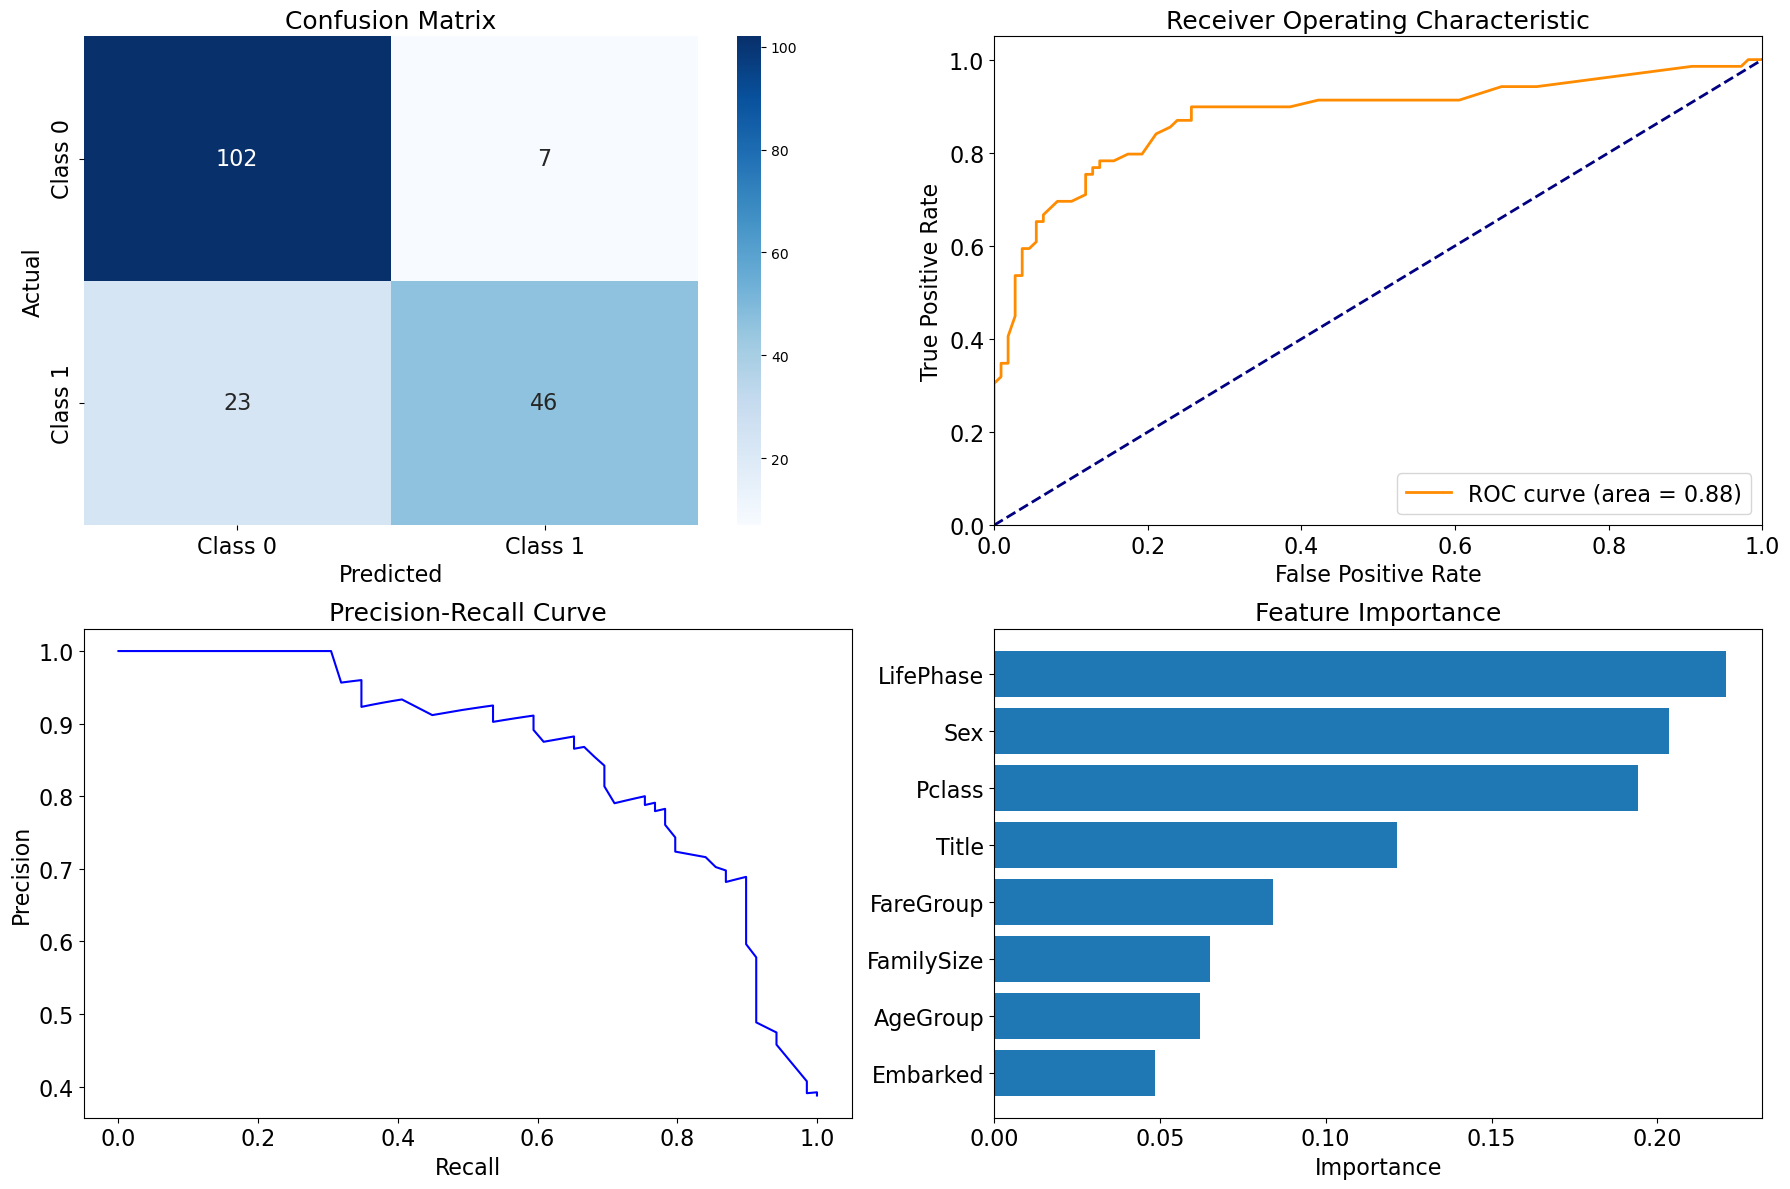

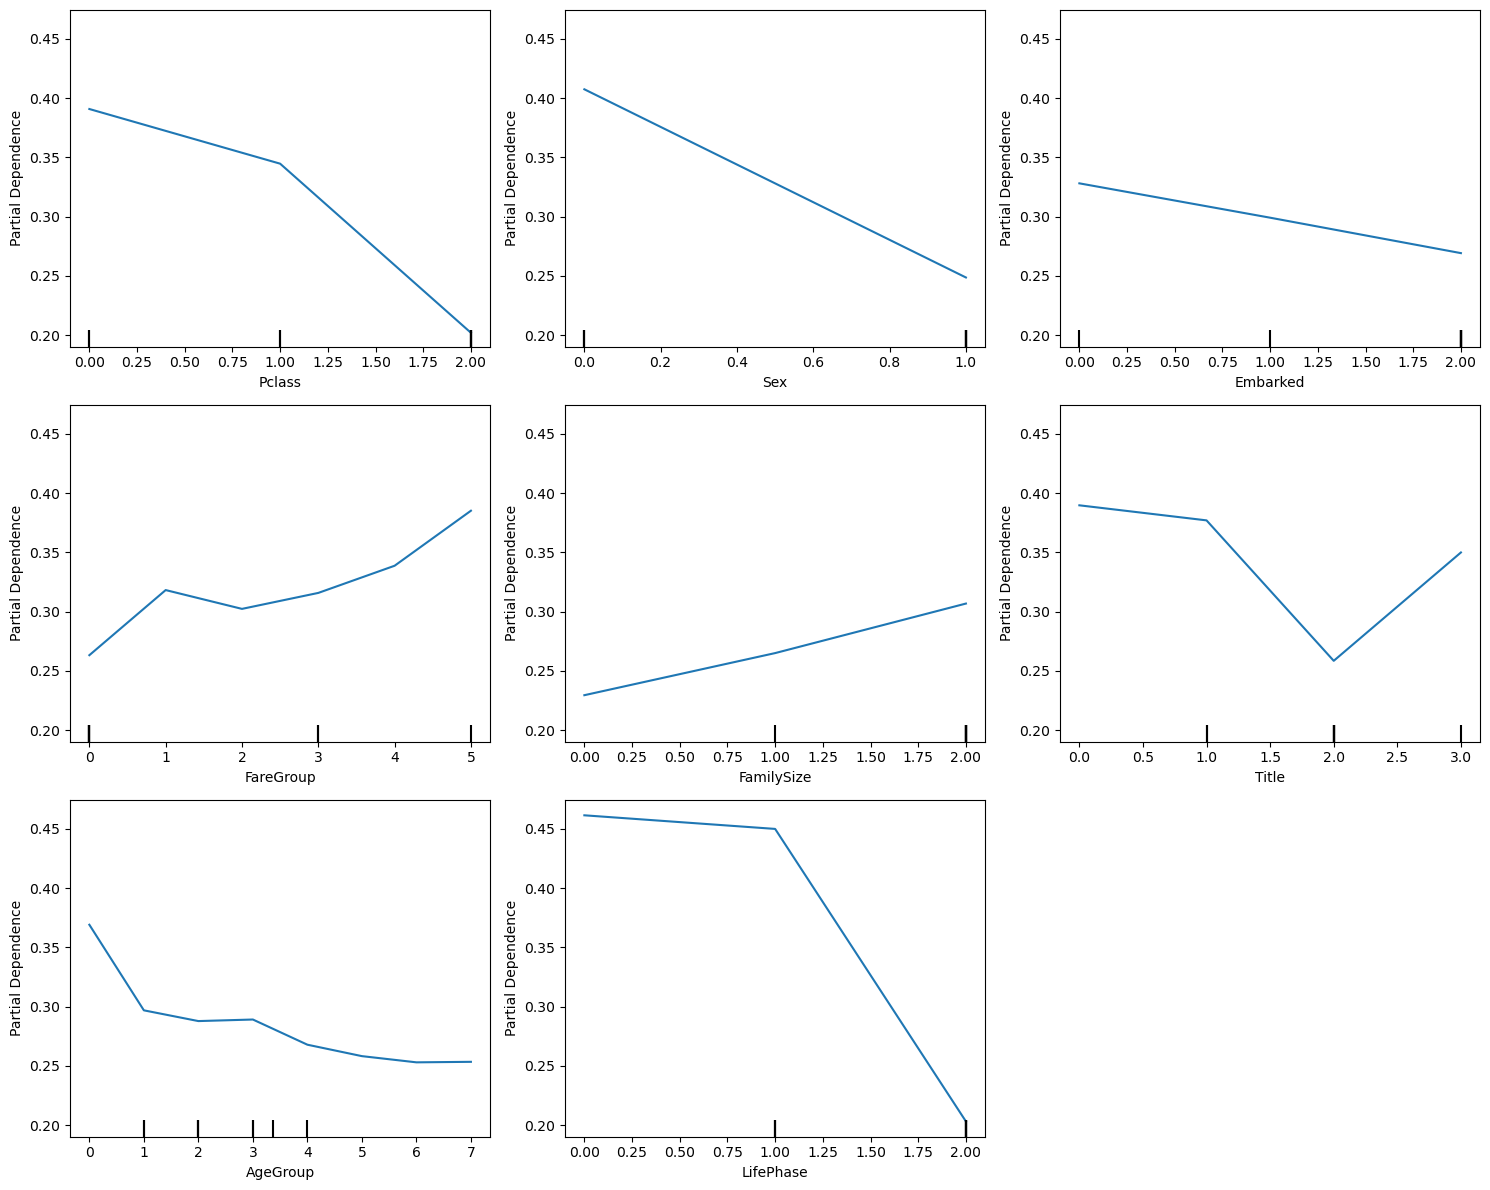

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest Classifier
randomforest_V3 = RandomForestClassifier(n_estimators=20000, random_state=42, min_samples_leaf=4, class_weight={0:0.72,1:0.28})
randomforest_V3.fit(X_train, y_train)

model = randomforest_V3
evaluate_model_performance_RF(model, X_val, y_val, X_train)

In [26]:
df = pd.DataFrame({"PassengerId": test_ids.values,
                   "Survived": randomforest_V3.predict(test)
                  })
# Save the DataFrame to a CSV file in the 'Submissions' folder
df.to_csv("Submissions/Submission_randomforest_V3.csv", index = False)